In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [6]:
import session_info
session_info.show()

In [2]:
# Import dataset
df = pd.read_csv("Datasets/MSFT_2023-01-13.csv")
print("Number of rows and columns:", df.shape)
df.tail(5)

Number of rows and columns: (14815, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
14810,2023-03-10 15:55:00-05:00,248.429993,248.470001,248.250000,248.330002,248.330002,115217
14811,2023-03-10 15:56:00-05:00,248.320007,248.330002,248.080002,248.132004,248.132004,109871
14812,2023-03-10 15:57:00-05:00,248.130005,248.630005,248.100006,248.619995,248.619995,194069
14813,2023-03-10 15:58:00-05:00,248.630005,248.740005,248.539993,248.690002,248.690002,188402
14814,2023-03-10 15:59:00-05:00,248.690002,248.740005,248.389999,248.600006,248.600006,316896


In [3]:
# Import model
model = keras.models.load_model('Models/03-13-2023')

In [3]:
# Train test split
# 1: Open, 2: High, 3: Low, 4: Close
training_set = df.iloc[:11000, 1:5].values
test_set = df.iloc[11000:, 1:5].values

print(training_set.shape)
print(test_set.shape)

(11000, 4)
(3815, 4)


In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 11000):
    X_train.append(training_set_scaled[i-60:i, 0:4])
    y_train.append(training_set_scaled[i, 0:4])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
#(840, 60, 1)
X_train.shape

(10940, 60, 4)

In [5]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 4)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 4))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
342/342 [==============================] - 71s 181ms/step - loss: 0.0105
Epoch 2/100
342/342 [==============================] - 55s 162ms/step - loss: 0.0039
Epoch 3/100
342/342 [==============================] - 59s 171ms/step - loss: 0.0025
Epoch 4/100
342/342 [==============================] - 52s 151ms/step - loss: 0.0022
Epoch 5/100
342/342 [==============================] - 59s 173ms/step - loss: 0.0017
Epoch 6/100
342/342 [==============================] - 60s 174ms/step - loss: 0.0016
Epoch 7/100
342/342 [==============================] - 59s 173ms/step - loss: 0.0013
Epoch 8/100
342/342 [==============================] - 61s 177ms/step - loss: 0.0013
Epoch 9/100
342/342 [==============================] - 63s 184ms/step - loss: 0.0011
Epoch 10/100
342/342 [==============================] - 63s 185ms/step - loss: 9.9325e-04
Epoch 11/100
342/342 [==============================] - 61s 179ms/step - loss: 9.0867e-04
Epoch 12/100
342/342 [==============================] -

342/342 [==============================] - 45s 133ms/step - loss: 4.3767e-04
Epoch 93/100
342/342 [==============================] - 49s 142ms/step - loss: 4.3464e-04
Epoch 94/100
342/342 [==============================] - 62s 182ms/step - loss: 4.7505e-04
Epoch 95/100
342/342 [==============================] - 60s 177ms/step - loss: 4.4159e-04
Epoch 96/100
342/342 [==============================] - 61s 177ms/step - loss: 4.3804e-04
Epoch 97/100
342/342 [==============================] - 60s 175ms/step - loss: 4.5921e-04
Epoch 98/100
342/342 [==============================] - 62s 181ms/step - loss: 4.5544e-04
Epoch 99/100
342/342 [==============================] - 61s 179ms/step - loss: 4.4039e-04
Epoch 100/100
342/342 [==============================] - 59s 173ms/step - loss: 4.3354e-04


In [6]:
# Save the model
model.save('Models/03-13-2023')

INFO:tensorflow:Assets written to: Models/03-13-2023\assets


INFO:tensorflow:Assets written to: Models/03-13-2023\assets


In [8]:
dataset_train = df.iloc[:11000, 1:5]
dataset_test = df.iloc[11000:, 1:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].to_numpy()
inputs = inputs.reshape(-1,4)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 3875):
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
print(X_test.shape)
# (300, 60, 1)
X_test.shape

(3815, 60, 4)


(3815, 60, 4)

In [9]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

120/120 [==============================] - 5s 33ms/step


(3815, 4)

In [8]:
predicted_stock_price[0: , 0].shape

(2333,)

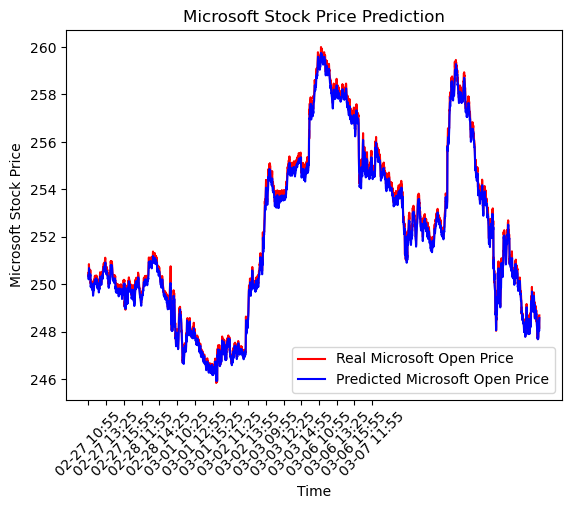

In [11]:
# Visualising the results
dfloc = df.loc[11000:, 'Date']

plt.plot(dfloc.str[5:16],dataset_test.Open.values, color = 'red', label = 'Real Microsoft Open Price')
plt.plot(dfloc.str[5:16],predicted_stock_price[0: , 0], color = 'blue', label = 'Predicted Microsoft Open Price')

plt.xticks(np.arange(0,2500,150), rotation=45)
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()

In [12]:
# Download predicted values into csv
predicted_prices_df = pd.DataFrame(predicted_stock_price, columns = ['Open','High','Low', 'Close'])
predicted_prices_df.to_csv (r'C:\Users\kayra\OneDrive\Desktop\Stonks 2022\Stocks-Prediction\Predictions\3-13-2023 Combined Model Price Prediction.csv', index = False, header=True)